# Download Lidar Tilesets and Perform MR classifcation

In [1]:
import src.modules.utils as util

In [2]:
# Download Las File to hard disk
las_fileID = 25192
year = 2017

Filename = str(las_fileID)+'.las'
External_Disk_Path = '/Volumes/Elements/Terravide/Datasets/FTP_files/LiDAR/'
util.FTP_download_lasfile(Filename,year,folderpath=External_Disk_Path)

"""TODO 
Iterate and download all ftp file

# Use below code snippet as referance 
filenames = ftp.nlst() # get filenames within the directory
print filenames

for filename in filenames:
    local_filename = os.path.join('C:\\test\\', filename)
    file = open(local_filename, 'wb')
    ftp.retrbinary('RETR '+ filename, file.write)

    file.close()

ftp.quit() # This is the “polite” way to close a connection

"""

[UTIL] Function - Datayear :  2017
File Exists


"TODO \nIterate and download all ftp file\n\n# Use below code snippet as referance \nfilenames = ftp.nlst() # get filenames within the directory\nprint filenames\n\nfor filename in filenames:\n    local_filename = os.path.join('C:\\test\\', filename)\n    file = open(local_filename, 'wb')\n    ftp.retrbinary('RETR '+ filename, file.write)\n\n    file.close()\n\nftp.quit() # This is the “polite” way to close a connection\n\n"

In [3]:
import src.modules.MultipleReturnsClassification as MRC
import time
import pptk
import numpy as np
import seaborn as sns 

from scipy.spatial.distance import pdist


In [4]:
#User Defines (Also in Utils)

def View3Dpoints(points, color=[[1,0,0]]):
    """Calls PPTK with basic config to plot 3d points

    Args:
        points (Nx3 Numpy Array): NX3 numpy array
    """
    exitViewerFlag = False
    while not exitViewerFlag:
        v = pptk.viewer(points, color*len(points))
        v.set(show_grid=False)
        v.set(show_axis=False)
        v.set(bg_color = [0,0,0,0])
        v.set(point_size = 0.0004)
        exitViewerFlag = int(input("Enter a 1 to exit viewer : "))

    v.close()

    return None

In [5]:
#Object to handle las preprocessing
LasHandling = MRC.LFP

#record start time of script
script_start = time.time()


TileDivision = 12
rows, cols = (TileDivision, TileDivision)


lasfilepath = External_Disk_Path+'NYC_'+str(year)+'/'+str(las_fileID)+'.las'

#Read las file
lasfile_object = LasHandling.Read_lasFile(lasfilepath)

#Create Dataframe from lasfile
lidar_df, rawpoints = LasHandling.Create_lasFileDataframe(lasfileObject=lasfile_object)

#Divide lidar_df into smaller portion for development
portion_size = 100 # 1-100 %
lidar_df = lidar_df.head(int(len(lidar_df)*(portion_size/100)))

#sanity check
pptk.viewer(lidar_df.iloc[:,:3].to_numpy())

In [6]:
#Extract MR and SR points from Dataframe
MR_df = LasHandling.Get_MRpoints(lidar_df)
SR_df = LasHandling.Get_SRpoints(lidar_df)

#lasTile class
TileObj_SR = MRC.MR_class(SR_df,TileDivision) #Single Return Points
TileObj_MR = MRC.MR_class(MR_df,TileDivision) #Multiple Return Points

#Serialized Creation of Lidar Subtiles
lidar_TilesubsetArr = TileObj_MR.Get_subtileArray()

# type(lidar_TilesubsetArr[0][0]) -> pandas.core.frame.DataFrame
# [[0]*self.cols for _ in range(self.rows)]

#---------------------------------------------------------------------

# #sanity check
# temp_segmentPoints = lidar_TilesubsetArr[1][0].iloc[:,:3].to_numpy()
# pptk.viewer(temp_segmentPoints)

# #MR points plot
# pptk.viewer(MR_df.iloc[:,:3].to_numpy())

# #SR points plot
# pptk.viewer(SR_df.iloc[:,:3].to_numpy())

In [7]:
#Print Lat , Long
ix, iy = np.mean(MR_df.X.to_numpy()), np.mean(MR_df.Y.to_numpy()) 

from pyproj import Transformer

transformer = Transformer.from_crs("epsg:2263", "epsg:4326")
lat, lon = transformer.transform(ix*3.28, iy*3.28)
print(str(lat)+","+str(lon))

40.69963574170024,-73.84812319726677


## Find optimal eps

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score # How best can we seperate clusters

from scipy.stats import ks_2samp #Check how different each distributions are

In [12]:


def Get_Optimal_EPS(points, step=0.2):

    #Find EPS ranges to try
    distances = pdist(points) # takes a while to find pdist with lots of points
    avgDist = round(np.mean(distances),3)
    eps_start = round(avgDist**(1/10),1)
    eps_end = eps_start + 0.5 #round(avgDist**(1/3),1)

    # eps_start  = 1.4
    # eps_end = 2.4
    # Logs 

    print("Avg Dist : ", avgDist)
    print("EPS 1 : ",eps_start)
    print("EPS 2 : ",eps_end)
    print("EPS ITER Count : ",(eps_end - eps_start)/0.1)

    S_score_eps_hashmap = {} # S_score -> eps
    range_eps = np.arange(eps_start, eps_end, step)
        #range_min_samples = [10,20,30,40,50]

    for ep in range_eps :
                
        db = DBSCAN(eps=ep, min_samples=60).fit(points)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_
        #print(set(labels))
        if(len(set(labels))) < 2 :
             return (1.5,0)
        silhouette_avg = silhouette_score(points, labels)
        print("For eps value = ",ep, "The average silhouette_score is :", silhouette_avg)

        if silhouette_avg not in S_score_eps_hashmap:
            S_score_eps_hashmap[silhouette_avg] = ep
        
        Best_eps = S_score_eps_hashmap[max(S_score_eps_hashmap)]
    
    return (round(Best_eps,1), max(S_score_eps_hashmap))

def Normalize_points(points):
    return points / np.linalg.norm(points)


In [13]:
Tilecounter = 0
Trees_Buffer = []

# Hashmap to store eps with distribution
EPS_Distribution_Hmap = {} # Df_Z -> eps

for row in range(3):
    for col in range(12):

        print('-'*40)
        
        print("TILE ID : ",Tilecounter)
        Tilecounter = Tilecounter + 1

        
        tile_segment_points = lidar_TilesubsetArr[row][col].iloc[:,:3].to_numpy()

        # tile_segment_points_X = lidar_TilesubsetArr[row][col].iloc[:,0].to_numpy()
        # tile_segment_points_Y = lidar_TilesubsetArr[row][col].iloc[:,1].to_numpy()
        # tile_segment_points_Z = lidar_TilesubsetArr[row][col].iloc[:,2].to_numpy()
        
        if (len(tile_segment_points) > 0):

            if not EPS_Distribution_Hmap: #Dict is empty
                
                #find optimal EPS
                Optimal_EPS, S_Score = Get_Optimal_EPS(tile_segment_points)

                # Mapping Z distribution -> eps value,  to check KS_statistic later to compare distribution
                EPS_Distribution_Hmap[tuple(tile_segment_points[:,2])] = [Optimal_EPS,S_Score]
            
            else: #Dict is not empty

                #Find Minimum KS statistic and check is KS statistic is less than 0.5 (arbitarily chosen)

                KS_stat_list = [] # Empty list for each tile to compare KS statistic as seen from previous tiles
                min_KS_stat_info = [100,-1] #[KS_stat, Key of dict after comparison] #default 100,-1

                for k in EPS_Distribution_Hmap.keys() : 

                    z1 = Normalize_points(k) # get Z_points from dict
                    z2 = Normalize_points(tile_segment_points[:,2]) # get Z_points from new tile

                    cur_statistic, pvalue = ks_2samp(z1, z2) #compare

                    #Logs
                    # print(f'K-S statistic (z): {cur_statistic:.3f}')
                    # print(f'p-value (z): {pvalue:.3f}')

                    #if pvalue < 0.05: #p < 0.05 , # NOTE: Not sure to include, maybe identical buildings?
                    KS_stat_list.append(cur_statistic) #add to list

                    if cur_statistic < min_KS_stat_info[0]:
                        #update best distribution
                        min_KS_stat_info[0] = cur_statistic
                        min_KS_stat_info[1] = k
                
                print("KS Stat : ",min_KS_stat_info[0])

                #NOTE : #if KS_statistic is significant (high) it represents that the 2 disttribtuions are very Different and likely drawn from different distributions

                if min_KS_stat_info[0] < 0.5: 

                    #get optimal eps from best matching distribution

                    Optimal_EPS, S_Score = EPS_Distribution_Hmap[min_KS_stat_info[1]] #Get the optimal eps and s_score by passing key (df_z values) of best match (low KS)
                else:

                    #Recalculate EPS and add it to hashmap 

                    #find optimal EPS
                    Optimal_EPS, S_Score = Get_Optimal_EPS(tile_segment_points)

                    # Mapping Z distribution -> eps value,  to check KS_statistic later to compare distribution
                    EPS_Distribution_Hmap[tuple(tile_segment_points[:,2])] = [Optimal_EPS,S_Score]
                    
                
            # Logs
            print("OPTIMAL EPS : ",Optimal_EPS)
            

            subTileTree_Points,  _ = TileObj_MR.Classify_MultipleReturns(tile_segment_points)

            for t in subTileTree_Points:
                Trees_Buffer.append(t)
            
            print("Trees added")

Trees_Buffer = np.array(Trees_Buffer)

pptk.viewer(Trees_Buffer)

----------------------------------------
TILE ID :  0
Avg Dist :  30.593
EPS 1 :  1.4
EPS 2 :  1.9
EPS ITER Count :  5.0
For eps value =  1.4 The average silhouette_score is : -0.44795794320865057
For eps value =  1.5999999999999999 The average silhouette_score is : -0.2735613349271298
For eps value =  1.7999999999999998 The average silhouette_score is : -0.2667813837864541
OPTIMAL EPS :  1.8
Trees added
----------------------------------------
TILE ID :  1
KS Stat :  0.2797038214358918
OPTIMAL EPS :  1.8
Trees added
----------------------------------------
TILE ID :  2
KS Stat :  0.18493390621607714
OPTIMAL EPS :  1.8
Trees added
----------------------------------------
TILE ID :  3
KS Stat :  0.5755880097138025
Avg Dist :  36.074
EPS 1 :  1.4
EPS 2 :  1.9
EPS ITER Count :  5.0
For eps value =  1.4 The average silhouette_score is : -0.5600984246867063
For eps value =  1.5999999999999999 The average silhouette_score is : -0.5122161650522695
For eps value =  1.7999999999999998 The avera

In [25]:
pptk.viewer(Trees_Buffer)

In [12]:
pptk.viewer(MR_df.iloc[:,:3].to_numpy())

In [13]:
for k in EPS_Distribution_Hmap.keys() : 

    z1 = Normalize_points(EPS_Distribution_Hmap[k]) # get Z_points from dict
    print(z1)

[0.98601513 0.16665581]
[0.98571926 0.16839699]
[0.99192859 0.12679778]
[1. 0.]
[ 0.99924675 -0.03880643]
[ 0.99975419 -0.02217133]
[ 0.99911455 -0.04207264]


In [14]:
hmap_Keys = EPS_Distribution_Hmap.keys()

for k in range(len(hmap_Keys)):
    print(k)
    print(len(hmap_Keys[k]))

    z1 = Normalize_points(EPS_Distribution_Hmap[hmap_Keys[k]]) # get Z_points from dict

0


TypeError: 'dict_keys' object does not support indexing

In [ ]:
t1 = Normalize_points(lidar_TilesubsetArr[0][0].iloc[:,:3].to_numpy())
t2 = Normalize_points(lidar_TilesubsetArr[0][1].iloc[:,:3].to_numpy())

/opt/anaconda3/envs/py36-test/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


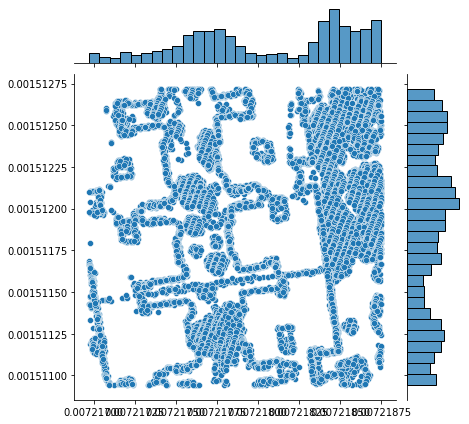

In [ ]:
sns.jointplot(t1[:,0], t1[:,1], kind='scatter')

In [ ]:
from scipy.stats import ks_2samp


# Extract the x and y coordinates from the point cloud datasets
x1 = t1[:,0]
y1 = t1[:,1]
z1 = t1[:,2]
x2 = t2[:,0]
y2 = t2[:,1]
z2 = t2[:,2]

# Perform the K-S test on the x coordinates
statistic, pvalue = ks_2samp(x1, x2)
print(f'K-S statistic (x): {statistic:.3f}')
print(f'p-value (x): {pvalue:.3f}')

# Perform the K-S test on the y coordinates
statistic, pvalue = ks_2samp(y1, y2)
print(f'K-S statistic (y): {statistic:.3f}')
print(f'p-value (y): {pvalue:.3f}')


#NOTE : Z value varies the most, if KS is large , there are from different distributions
# Perform the K-S test on the z coordinates
statistic, pvalue = ks_2samp(z1, z2)
print(f'K-S statistic (z): {statistic:.3f}')
print(f'p-value (z): {pvalue:.3f}')

K-S statistic (x): 1.000
p-value (x): 0.000
K-S statistic (y): 1.000
p-value (y): 0.000
K-S statistic (z): 0.082
p-value (z): 0.000


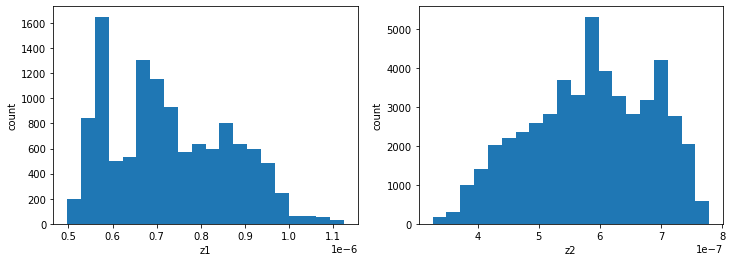

In [ ]:
import matplotlib.pyplot as plt

z1 = norm1[:,2]
z2 = norm2[:,2]

# Set up the figure and axes for the histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

# Plot the histogram for the z1 norm1
ax1.hist(z1, bins=20)
ax1.set_xlabel('z1')
ax1.set_ylabel('count')

# Plot the histogram for the z2 norm2
ax2.hist(z2, bins=20)
ax2.set_xlabel('z2')
ax2.set_ylabel('count')


# Show the figure
plt.show()


In [ ]:
# Tilecounter = 0

Trees_Buffer = []
for row in range(1):
    for col in range(1):
        # print(Tilecounter)
        # Tilecounter = Tilecounter + 1

        tile_segment_points = lidar_TilesubsetArr[row][col].iloc[:,:3].to_numpy()
        
        subTileTree_Points,  _ = TileObj_MR.Classify_MultipleReturns(tile_segment_points,hp_eps=2)

        for t in subTileTree_Points:
            Trees_Buffer.append(t)

Trees_Buffer = np.array(Trees_Buffer)

pptk.viewer(Trees_Buffer)

In [ ]:
print("Multiple Returns Classifcation Algorithm : FILDE ID - {}".format(las_fileID))

#setting static eps for entire tile

# tile_segment_points = lidar_TilesubsetArr[TileDivision//2][TileDivision//2].iloc[:,:3].to_numpy()

# distances = pdist(tile_segment_points)
# avgDist = np.mean(distances)
# eps = avgDist**(1/3)

# print("Avg Dist : ", avgDist)
# print("EPS : ",eps)

#Counter : Iterating through each tile
Tilecounter = 0

start = time.time()
Trees_Buffer = []
for row in range(TileDivision):
    for col in range(TileDivision):
        print(Tilecounter)
        Tilecounter = Tilecounter + 1

        tile_segment_points = lidar_TilesubsetArr[row][col].iloc[:,:3].to_numpy()

        distances = pdist(tile_segment_points[:,:2])
        avgDist = np.mean(distances)
        eps = avgDist**(1/4)

        print("Avg Dist : ", avgDist)
        print("EPS : ",eps)
        
        subTileTree_Points,  _ = TileObj_MR.Classify_MultipleReturns(tile_segment_points,eps)

        for t in subTileTree_Points:
            Trees_Buffer.append(t)

end = time.time()
MRtime = end - start
print("MR Point Classification Algorithm Time : ",MRtime)

print("Displaying Tree points")
pptk.viewer(Trees_Buffer)

Multiple Returns Classifcation Algorithm : FILDE ID - 7252
0
Avg Dist :  20.020462684706374
EPS :  2.115283235838168
1
Avg Dist :  21.22084267269777
EPS :  2.146301140771714
2
Avg Dist :  20.882087982739392
EPS :  2.137683870246342
3
Avg Dist :  9.755550313640029
EPS :  1.7673108482173312
4
Avg Dist :  nan
EPS :  nan
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
5
Avg Dist :  nan
EPS :  nan
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
6
Avg Dist :  2.0227307611960974
EPS :  1.1925717564719993
7
Avg Dist :  16.48673955571501
EPS :  2.0150401054032714


/opt/anaconda3/envs/py36-test/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/py36-test/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


8
Avg Dist :  18.243840884148938
EPS :  2.066707754338463
9
Avg Dist :  27.0261288985864
EPS :  2.2800583477523726
10
Avg Dist :  19.257942508083392
EPS :  2.0948477828116965
11
Avg Dist :  17.347359101657542
EPS :  2.0408371073182807
12
Avg Dist :  14.331474150013213
EPS :  1.94568583057275
13
Avg Dist :  20.802835963203478
EPS :  2.135652734606734
14
Avg Dist :  18.641298153184866
EPS :  2.07787318328856
15
Avg Dist :  22.206059121121996
EPS :  2.170790303163405
16
Avg Dist :  14.206197440851682
EPS :  1.9414198313604887
17
Avg Dist :  19.428426635379868
EPS :  2.099468717417357
18
Avg Dist :  22.455957091162592
EPS :  2.1768719957562777
19
Avg Dist :  19.027469616448425
EPS :  2.088551839570573
20
Avg Dist :  9.851572137858899
EPS :  1.7716437050628664
21
Avg Dist :  14.239770545148659
EPS :  1.942565841868216
22
Avg Dist :  22.71258718796442
EPS :  2.1830649245911817
23
Avg Dist :  16.551353915597247
EPS :  2.0170115323200593
24
Avg Dist :  15.058657484236086
EPS :  1.9699108117098

/opt/anaconda3/envs/py36-test/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/py36-test/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Avg Dist :  22.764420420737103
EPS :  2.1843093733378813
49
Avg Dist :  23.779798045629615
EPS :  2.2082693289187914
50
Avg Dist :  17.84347059284557
EPS :  2.0552744925543864
51
Avg Dist :  24.76316196368161
EPS :  2.230753199444852
52
Avg Dist :  25.456710835240333
EPS :  2.2462111170850068
53
Avg Dist :  21.852761269159345
EPS :  2.1621040004109515
54
Avg Dist :  18.23213368634101
EPS :  2.0663761193883765
55
Avg Dist :  14.807004031244707
EPS :  1.961628662686938
56
Avg Dist :  12.471955873935617
EPS :  1.8792460298241387
57
Avg Dist :  nan
EPS :  nan
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
58
Avg Dist :  nan
EPS :  nan
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
59
Avg Dist :  11.743885517547577
EPS :  1.8511983403214156
60
Avg Dist :  21.259837403636
EPS :  2.147286455371533
61
Avg Dist :  21.88566101875081
EPS :  2.162917313602903
62
Avg Dist :  23.956622839111812
EPS :  2.2123630625236004
63
Avg Dist :  23.002077489533857
EPS :  2

/opt/anaconda3/envs/py36-test/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/py36-test/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


: 

: 